# Assignment 4: Neural Networks

---

## Task 1) Skip-grams

Tomas Mikolov's [original paper](https://arxiv.org/abs/1301.3781) for word2vec is not very specific on how to actually compute the embedding matrices.
Xin Ron provides a much more detailed [walk-through](https://arxiv.org/pdf/1411.2738.pdf) of the math, I recommend you go through it before you continue with this assignment.
Now, while the original implementation was in C and estimates the matrices directly, in this assignment, we want to use PyTorch (and autograd) to train the matrices.
There are plenty of example implementations and blog posts out there that show how to do it, I particularly recommend [Mateusz Bednarski's](https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb) version. Familiarize yourself with skip-grams and how to train them using pytorch.

### Data

Download the `theses.csv` data set from the `Supplemental Materials` in the `Files` section of our Microsoft Teams group.
This dataset consists of approx. 3,000 theses topics chosen by students in the past.
Here are some examples of the file content:

```
27.10.94;14.07.95;1995;intern;Diplom;DE;Monte Carlo-Simulation für ein gekoppeltes Round-Robin-System;
04.11.94;14.03.95;1995;intern;Diplom;DE;Implementierung eines Testüberdeckungsgrad-Analysators für RAS;
01.11.20;01.04.21;2021;intern;Bachelor;DE;Landessprachenerkennung mittels X-Vektoren und Meta-Klassifikation;
```

### Basic Setup

For the upcoming assignments on Neural Networks, we'll be heavily using [PyTorch](https://pytorch.org) as go-to Deep Learning library.
If you're not already familiar with PyTorch, now's the time to get started with it.
Head over to the [Basics](https://pytorch.org/tutorials/beginner/basics/intro.html) and gain some understanding about the essentials.
Before starting this assignment, make sure you've got PyTorch installed in your working environment. 
It's a quick setup, and you'll find all the instructions you need on the PyTorch website.
As always, you can use [NumPy](https://numpy.org) and [Pandas](https://pandas.pydata.org) for data handling etc.

*In this Jupyter Notebook, we will provide the steps to solve this task and give hints via functions & comments. However, code modifications (e.g., function naming, arguments) and implementation of additional helper functions & classes are allowed. The code aims to help you get started.*

---

In [37]:
# Dependencies
import numpy as np
import pandas as pd
import torch
import csv
from typing import TypedDict, Iterator, Iterable, Optional
from dataclasses import dataclass
import re
from math import floor, ceil
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Prepare the Data

1.1 Spend some time on preparing the dataset. It may be helpful to lower-case the data and to filter for German titles. The format of the CSV-file should be:

```
Anmeldedatum;Abgabedatum;JahrAkademisch;Art;Grad;Sprache;Titel;Abstract
```

1.2 Create the vocabulary from the prepared dataset. You'll need it for the initialization of the matrices and to map tokens to indices.

1.3 Generate the training pairs with center word and context word. Which window size do you choose?

In [4]:
DATASET_PATH = "data/theses2022.csv"

@dataclass
class Thesis:
    registration_date: str
    due_date: str
    year_academic: int
    type: str
    degree: str
    language: str
    title: str
    abstract: str

class _Thesis(TypedDict):
    Anmeldedatum: str
    Abgabedatum: str
    JahrAkademisch: str
    Art: str
    Grad: str
    Sprache: str
    Titel: str
    Abstract: str

def to_thesis(thesis: _Thesis) -> Thesis:
    return Thesis(
        registration_date=thesis["Anmeldedatum"],
        due_date=thesis["Abgabedatum"],
        year_academic=int(thesis["JahrAkademisch"]),
        type=thesis["JahrAkademisch"],
        degree=thesis["Grad"],
        language=thesis["Sprache"],
        title=thesis["Titel"],
        abstract=thesis["Abstract"]
    )

def load_theses_dataset(filepath) -> pd.DataFrame:
    """Loads all theses instances and returns them as a dataframe."""
    ### YOUR CODE HERE

    lists = {key: [] for key in Thesis.__dataclass_fields__.keys()}
    with open(filepath, encoding="utf-8-sig") as fp:
        theses = map(to_thesis, csv.DictReader(fp.readlines(), delimiter=";")) # type: ignore
        for thesis in theses:
            for key in lists:
                lists[key].append(thesis.__dict__[key])
    return pd.DataFrame(lists)
    
    ### END YOUR CODE

dataset = load_theses_dataset(DATASET_PATH)

In [5]:
def tokenize(text: str) -> Iterator[str]:
    for s in text.split():
        m = re.match(r"^([@#]?\w+)[,\.?!]?$", s)
        if m is not None:
            yield m.group(1)

def preprocess(dataframe: pd.DataFrame) -> list[list[str]]:
    """Preprocesses and tokenizes the given theses titles for further use."""
    ### YOUR CODE HERE
    
    l = []
    for i in range(len(dataframe)):
        if dataframe["language"][i] == "DE":
            l.append(list(tokenize(dataframe["title"][i])))
            l.append(list(tokenize(dataframe["abstract"][i])))
    return l
    
    ### END YOUR CODE

In [6]:
NEGATIVE_SAMPLING_RATIO = 3

def word_frequencies(word2idx: dict[str, int], data: Iterable[str]) -> np.ndarray:
    counts = np.zeros(len(word2idx), np.int32)
    total = 0
    for w in data:
        counts[word2idx[w]] += 1
        total += 1
    return counts / total

def draw_idx(word_frequencies: np.ndarray) -> int:
    return np.random.choice(word_frequencies.shape[0], p=word_frequencies)

def create_training_pairs(data: list[list[str]], word2idx: dict[str, int], window_size: int) -> list[tuple[int, list[int], list[int]]]:
    """Creates training pairs based on skip-grams for further use."""
    ### YOUR CODE HERE
    
    data = list(filter(lambda l: len(l) > 2 * window_size, data))
    freqs = word_frequencies(word2idx, (w for l in data for w in l))
    negative_count = NEGATIVE_SAMPLING_RATIO * window_size
    result = []
    for l in data:
        for i in range(window_size, len(l) - window_size):
            center = word2idx[l[i]]
            positive = []
            for j in range(i - window_size, i):
                positive.append(word2idx[l[j]])
            for j in range(i + 1, i + window_size + 1):
                positive.append(word2idx[l[j]])
            pos_set = set(positive)
            neg_set = set()
            while len(neg_set) < negative_count:
                neg = draw_idx(freqs)
                if not neg in pos_set:
                    neg_set.add(neg)
            result.append((center, positive, list(neg_set)))
    return result

    ### END YOUR CODE

In [7]:
dataframe = load_theses_dataset(DATASET_PATH)
tokenized_data = preprocess(dataframe)
vocabulary = {w for l in tokenized_data for w in l}
word2idx = {w: i for i, w in enumerate(vocabulary)}
idx2word = list(vocabulary)
training_pairs = create_training_pairs(tokenized_data, word2idx, 2)

### Train and Analyze

2.1 Implement and train the word2vec model with your training data.

2.2 Implement a method to find the top-k similar words for a given word (token).

2.3 Analyze: What are the most similar words to "Konzeption", "Cloud" and "virtuelle"?

In [31]:
### TODO: 2.1 Implement and train the word2vec model.

### YOUR CODE HERE

@dataclass
class Batch:
    x_in: torch.Tensor
    x_out: torch.Tensor
    p: torch.nn.Parameter
    o: torch.nn.Parameter
    y: torch.Tensor
    p_idcs: list[int]
    o_idcs: list[int]

    def __del__(self):
        del self.x_in
        del self.x_out
        del self.p
        del self.o
        del self.y
        del self.p_idcs
        del self.o_idcs
        

class BatchAllocator(Iterable[Batch]):
    @property
    def batch_size(self) -> int:
        return self.__batch_size
    
    @property
    def device(self) -> torch.device:
        return self.__device

    def __init__(self, batch_size: int, data_list: list[tuple[int, list[int], list[int]]], device: torch.device):
        self.__batch_size = batch_size
        self.__data_list = data_list
        self.__device = device
        self.__samples_per_input = len(data_list[0][1]) + len(data_list[0][2])
        self.P = torch.tensor(0)
        self.O = torch.tensor(0)

    def __iter__(self) -> Iterator[Batch]:
        for idcs in self.__idcs():
            yield self.__allocate_batch(idcs)
    
    def __len__(self) -> int:
        return ceil(len(self.__data_list) / self.batch_size)    

    def __allocate_batch(self, idcs: tuple[int, int]) -> Batch:
        i, j = idcs
        size = j - i
        p_idx_set = set()
        o_idx_set = set()
        for center, positive, negative in (self.__data_list[k] for k in range(i, j)):
            p_idx_set.add(center)
            for l in positive:
                o_idx_set.add(l)
            for l in negative:
                o_idx_set.add(l)
        p_idcs = list(p_idx_set)
        o_idcs = list(o_idx_set)
        x_in = torch.zeros((size, 1, len(p_idcs)), dtype=torch.float32,)
        p = torch.empty((1, len(p_idcs), self.P.shape[1]), dtype=torch.float32)
        o = torch.empty((1, self.O.shape[1], len(o_idcs)), dtype=torch.float32)
        x_out = torch.zeros((size, len(o_idcs), self.__samples_per_input), dtype=torch.float32)
        y = torch.hstack((
            torch.ones((size, len(self.__data_list[0][1])), dtype=torch.float32, device=self.device),
            torch.zeros((size, len(self.__data_list[1][2])), dtype=torch.float32, device=self.device)
        ))
        for k in range(size):
            center, positive, negative = self.__data_list[i + k]
            x_in[k, 0, p_idcs.index(center)] = 1
            for l in range(len(positive)):
                x_out[k, o_idcs.index(positive[l]), l] = 1
                y[k, l] = 1
            for l in range(len(negative)):
                x_out[k, o_idcs.index(negative[l]), l + len(positive)] = 1
        for row, p_idx in enumerate(p_idcs):
            p[0, row, :] = self.P[p_idx, :]
        for col, o_idx in enumerate(o_idcs):
            o[0, :, col] = self.O[o_idx, :]
        return Batch(x_in.to(self.device), x_out.to(self.device), torch.nn.Parameter(p.to(self.device)), torch.nn.Parameter(o.to(self.device)), y, p_idcs, o_idcs) # type: ignore

    def __idcs(self) -> Iterator[tuple[int, int]]:
        i = 0
        for _ in range(floor(len(self.__data_list) / self.batch_size)):
            j = i + self.batch_size
            yield i, j
            i = j
        if i < len(self.__data_list):
            yield i, len(self.__data_list)

def word2vec(voc_size: int, data_list: list[tuple[int, list[int], list[int]]], dim: int, batch_size: int, epochs: int, lr: float, device: Optional[torch.device] = None) -> torch.Tensor:
    if device == None:
        device = torch.device("cpu")
    P = torch.rand((voc_size, dim))
    O = torch.rand((voc_size, dim))
    allocator = BatchAllocator(batch_size, data_list, device)
    allocator.P = P
    allocator.O = O
    batch_count = len(allocator)
    for e in range(1, epochs + 1):
        print(f"training epoch {e}/{epochs}...")
        running_loss = 0
        for k, batch in enumerate(allocator):
            print(f"\r    batch {k + 1}/{batch_count}", end="")
            opt = torch.optim.SGD([batch.p, batch.o], lr)
            opt.zero_grad()
            logits = (batch.x_in @ batch.p @ batch.o @ batch.x_out).flatten(end_dim=1)
            loss = torch.nn.functional.cross_entropy(logits, batch.y)
            running_loss += loss.item()
            loss.backward()
            opt.step()
            with torch.no_grad():
                for i, j in enumerate(batch.p_idcs):
                    P[j, :] = batch.p[0, i, :]
                for i, j in enumerate(batch.o_idcs):
                    O[j, :] = batch.o[0, :, i]
            del opt
            del loss
            del logits
            del batch
        print()
        print(f"    average loss: {running_loss / batch_count}")
    return P + O

M = word2vec(len(idx2word), training_pairs, 300, 64, 100, 0.3)     

### END YOUR CODE

training epoch 1/100...
    batch 1834/1834
    average loss: 13.329922548167188
training epoch 2/100...
    batch 1834/1834
    average loss: 10.964425131694831
training epoch 3/100...
    batch 1834/1834
    average loss: 10.181577068898774
training epoch 4/100...
    batch 1834/1834
    average loss: 9.719602912956912
training epoch 5/100...
    batch 1834/1834
    average loss: 9.395797439333917
training epoch 6/100...
    batch 1834/1834
    average loss: 9.1462579030897
training epoch 7/100...
    batch 1834/1834
    average loss: 8.939724311963813
training epoch 8/100...
    batch 1834/1834
    average loss: 8.775527920041766
training epoch 9/100...
    batch 1834/1834
    average loss: 8.627199096534088
training epoch 10/100...
    batch 1834/1834
    average loss: 8.500983898876278
training epoch 11/100...
    batch 1834/1834
    average loss: 8.388550286724627
training epoch 12/100...
    batch 1834/1834
    average loss: 8.291289253869259
training epoch 13/100...
    batch 1

In [32]:
### TODO: 2.2 Implement a method to find the top-k similar words.

### YOUR CODE HERE

def nearest_neighbours(query: str, word2idx: dict[str, int], V: list[str], M: torch.Tensor, k: int):
    query_idx = word2idx[query]
    scores = M[query_idx, :] @ M.T
    top_idcs = [-1 for _ in range(k)]
    for i in range(scores.shape[0]):
        if not i == query_idx:
            for j in range(k):
                if top_idcs[j] == -1 or scores[top_idcs[j]] < scores[i]:
                    top_idcs.insert(j, i)
                    del top_idcs[-1]
                    break
    count = k
    while top_idcs[k-1] == -1:
        count -= 1
    result = []
    for j in range(count):
        i = top_idcs[j]
        result.append((idx2word[i], scores[i].item()))
    return result

### END YOUR CODE

In [33]:
### TODO: 2.3 Find the most similar words for "Konzeption", "Cloud" and "virtuelle".

### YOUR CODE HERE

print(nearest_neighbours("Konzeption", word2idx, idx2word, M, 5))
print(nearest_neighbours("Cloud", word2idx, idx2word, M, 5))
print(nearest_neighbours("virtuelle", word2idx, idx2word, M, 5))

### END YOUR CODE

[('Hauptteile', 229.1881866455078), ('integrierten', 223.59689331054688), ('Nutzweranalyse', 223.5181427001953), ('zusteuert', 223.23220825195312), ('konkurrierende', 222.9911346435547)]
[('Dann', 315.9914855957031), ('schafft', 314.2419128417969), ('Beratungsforums', 313.81414794921875), ('Testdatensätze', 313.0927429199219), ('vielversprechendes', 313.0432434082031)]
[('Auswertungstool', 310.2977294921875), ('allgemeinere', 309.85821533203125), ('Beratungsforums', 309.698974609375), ('unnatürlich', 309.59332275390625), ('Nächstes', 308.993408203125)]


### Play with the Embeddings

3.1 Use the computed embeddings: Can you identify the most similar theses for some examples?

3.2 Visualize the embeddings for a subset of theses using [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use [Scikit-Learn](https://scikit-learn.org/stable/) and [Matplotlib](https://matplotlib.org) or [Seaborn](https://seaborn.pydata.org).

In [54]:
### TODO: 3.1 Compute the embeddings for the theses and transform with TSNE.

### YOUR CODE HERE

SAMPLE_COUNT = 100

def thesis_embedding(thesis: Thesis, word2idx: dict[str, int], M: torch.Tensor) -> torch.Tensor:
    total = torch.zeros(M.shape[1], dtype=M.dtype)
    for i in map(lambda t: word2idx[t], tokenize(thesis.title)):
        total += M[i, :]
    for i in map(lambda t: word2idx[t], tokenize(thesis.abstract)):
        total += M[i, :]
    return total / total.norm()

embedding_list = []
for d in dataframe.to_dict("records"):
    if len(embedding_list) == SAMPLE_COUNT:
        break
    if d["language"] == "DE":
        embedding_list.append(thesis_embedding(Thesis(**d), word2idx, M).numpy()) # type: ignore
embeddings = np.array(embedding_list)

tsne = TSNE(2)
transformed = tsne.fit_transform(embeddings)

### END YOUR CODE

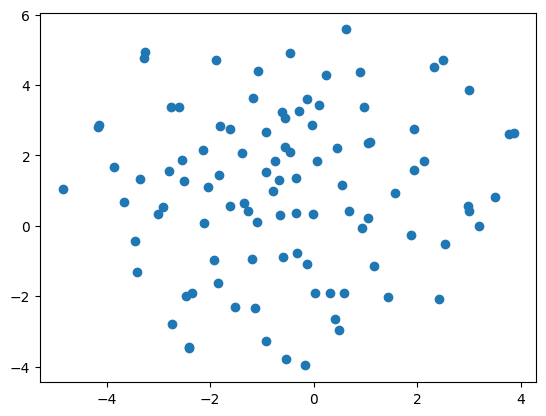

In [55]:
### TODO: 3.2 Visualize the samples in the 2D space.

### YOUR CODE HERE

plt.scatter(transformed[:, 0], transformed[:, 1])

### END YOUR CODE